In [1]:
import os
import torch
import torchvision
from d2l import torch as d2l

In [6]:
voc_dir =   d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
# voc_dir = os.path.join('/public/data/image/voc2012', 'VOCdevkit', 'VOC2012' )

In [7]:
def read_voc_images(voc_dir, is_train=True):
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                                                            'train.txt' if is_train else 'val.txt')
    # png 图片含有 Alpha 通道，使用RGB 忽略Alpha通道
    mode = torchvision.io.image.ImageReadMode.RGB
    # images 是文件名字列表    
    with  open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i , fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
                        voc_dir,    'JPEGImages', f'{fname}.jpg'   )))
        labels.append( torchvision.io.read_image( os.path.join( 
                        voc_dir, 'SegmentationClass', f'{fname}.png'   ), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, is_train=True)

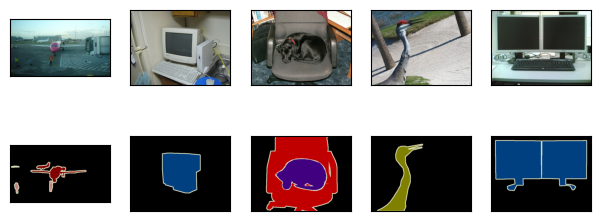

In [8]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1, 2, 0) for  img in imgs]
d2l.show_images(imgs, 2, 5);

In [9]:
VOC_COLORMAP = [ [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                                        [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                                        [64, 0, 0] , [192, 0, 0], [64, 128, 0], [192, 128, 0],
                                        [64, 0 ,128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                                        [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], 
                                        [0, 64, 128] ]

VOC_CLASSES = [  'backgroud', 'aerolpane', 'bicycle', 'bird', 'boat', 
                                        'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
                                           'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                                              'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'   ]


In [10]:
def voc_colormap2label():
    colormap2label = torch.zeros( 256 ** 3,dtype=torch.long)
    for i , colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
        # 按照真实的 color 构建对应的  映射矩阵
    return colormap2label

def voc_label_indices( colormap, colormap2label):
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    # 按照通道 RGB 加权，得到 颜色对应的 label 的 索引
    idx = (colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]

    return colormap2label[idx]

In [11]:
# 将 原图 每个像素 标记上类别
y = voc_label_indices( train_labels[0], voc_colormap2label())
y[ 105:115, 130 : 140], VOC_CLASSES[1], y.shape, train_labels[0].shape

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aerolpane',
 torch.Size([281, 500]),
 torch.Size([3, 281, 500]))

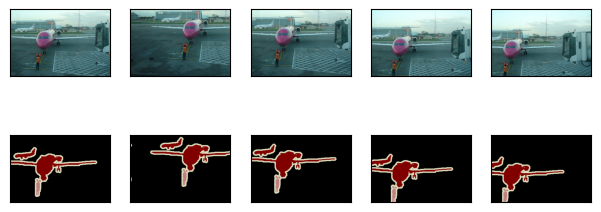

In [12]:
import torchvision.transforms.functional


def voc_rand_crop(feature, label, height, width):
    # 要裁剪的图片， 输出形状
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width) )
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    # imgs [ 原图， 标签， 原图， 标签 ... ]
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200 , 300)
imgs = [img.permute(1, 2, 0) for img in imgs]
imgs[0].shape, len(imgs)
d2l.show_images(imgs[: : 2] + imgs[1:: 2], 2, n);

In [13]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[ 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read  ' + f'{len(self.features)}  ' + 'examples')
    def filter(self, imgs):
        return [ img for img in imgs if (
                        img.shape[1] >= self.crop_size[0] and
                        img.shape[2] >= self.crop_size[1] )]
    def normalize_image(self, img):
        return self.transform(img.float() / 255)
    
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],*self.crop_size)
        return  (feature, voc_label_indices(label, self.colormap2label))
    def __len__(self):
        return len(self.features)



In [14]:
crop_size = (320, 480)

voc_train = VOCSegDataset(is_train=True, crop_size=crop_size, voc_dir=voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read  1114  examples
read  1078  examples


In [15]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                         drop_last=True, num_workers=d2l.get_dataloader_workers())


for x, y in train_iter:
    print(x.shape)
    print(y.shape)
    break

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [16]:
def load_data_voc(batch_size, crop_size):
    voc_dir = d2l.download_extract('voc2012', os.path.join(
                            'VOCdevkit', 'VOC2012'  ))
    # voc_dir = os.path.join('/public/data/image/voc2012', 'VOCdevkit', 'VOC2012' )
    num_works= d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
                                                                        VOCSegDataset(True, crop_size,voc_dir),
                                                                         batch_size, shuffle=True, drop_last=True, 
                                                                         num_workers=num_works)
    test_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size,voc_dir), 
                                                                        batch_size, drop_last=True, num_workers=num_works)
    
    return train_iter, test_iter
    
    